Import libraries

In [1]:
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from collections import defaultdict
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW, Adam
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_

from transformers import set_seed
from transformers import AdamWeightDecay
from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForSequenceClassification #, BertModel, BertTokenizer

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle


Specify a constant seeder for processes

In [3]:
seeders = [123456, 789012, 345678, 901234, 567890, 123, 456, 789, 123, 456]

seed = seeders[0]

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

Pre-trained tokenizer

In [4]:
model_variation = "microsoft/codebert-base-mlm"
tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#bert-base-uncased #bert-base # roberta-base # distilbert-base-uncased #distilbert-base # microsoft/codebert-base-mlm
# 'albert-base-v2'

# tokenizer = RobertaTokenizer(vocab_file="../../tokenizer_training/cpp_tokenizer/cpp_tokenizer-vocab.json",
#                              merges_file="../../tokenizer_training/cpp_tokenizer/cpp_tokenizer-merges.txt")

Read dataset

In [5]:
root_path = os.path.join('..', '..', '..')
dataset = pd.read_csv(os.path.join(root_path, 'data', 'train.csv'))

Shuffle dataset

In [6]:
data = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
print(data.head())
print(len(data))

    index Access Gained Attack Origin Authentication Required Availability  \
0  167605           NaN        Remote            Not required          NaN   
1  142713           NaN           NaN                     NaN          NaN   
2  123912           NaN        Remote            Not required      Partial   
3   53817           NaN         Local            Not required     Complete   
4   29110           NaN         Local            Not required     Complete   

           CVE ID                                        CVE Page   CWE ID  \
0  CVE-2018-16073  https://www.cvedetails.com/cve/CVE-2018-16073/  CWE-285   
1             NaN                                             NaN      NaN   
2   CVE-2013-0918   https://www.cvedetails.com/cve/CVE-2013-0918/  CWE-264   
3   CVE-2016-3699   https://www.cvedetails.com/cve/CVE-2016-3699/  CWE-264   
4   CVE-2013-4591   https://www.cvedetails.com/cve/CVE-2013-4591/  CWE-119   

  Complexity Confidentiality  ... parentID  \
0     Medium    

In [7]:
data = data[data["project"] != "Chrome"]
print(len(data))

89145


In [8]:
data = data[["processed_func", "target"]]
data.head()

,processed_func,target
3,"ssize_t acpi_debugger_read_cmd(char *buffer, s...",0
4,static int _nfs41_test_stateid(struct nfs_serv...,0
8,GF_Box *rvcc_New()\n{\n\tISOM_DECL_BOX_ALLOC(G...,0
11,"static int snd_seq_open(struct inode *inode, s...",0
14,"char **XGetFontPath(\nregister Display *dpy,\n...",1


Explore data

In [9]:
data = data.dropna(subset=["processed_func"])

In [5]:
word_counts = data["processed_func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)

NameError: name 'data' is not defined

In [11]:
vc = data["target"].value_counts()

print(vc)

print("Percentage: ", (vc[1] / vc[0])*100, '%')

n_categories = len(vc)
print(n_categories)

target
0    83578
1     5567
Name: count, dtype: int64
Percentage:  6.660843762712676 %
2


In [12]:
train_data = pd.DataFrame(({'Text': data['processed_func'], 'Labels': data['target']}))
#data = data[0:100]
train_data.head()

,Text,Labels
3,"ssize_t acpi_debugger_read_cmd(char *buffer, s...",0
4,static int _nfs41_test_stateid(struct nfs_serv...,0
8,GF_Box *rvcc_New()\n{\n\tISOM_DECL_BOX_ALLOC(G...,0
11,"static int snd_seq_open(struct inode *inode, s...",0
14,"char **XGetFontPath(\nregister Display *dpy,\n...",1


Split to train-val-test

In [8]:
val_data = pd.read_csv(os.path.join(root_path, 'data', 'val.csv'))

val_data = val_data[val_data["project"] != "Chrome"]

val_data = pd.DataFrame(({'Text': val_data['processed_func'], 'Labels': val_data['target']}))
val_data.head()

,Text,Labels
1,int iwlagn_add_bssid_station(struct iwl_priv *...,0
2,"static int dnxhd_init_vlc(DNXHDContext *ctx, u...",0
3,void CameraService::onFirstRef()\n{\n LOG1(...,0
4,int EmbedStream::getChar() {\n if (limited &&...,0
5,"json_t *json_rpc_call(CURL *curl, const char *...",0


In [9]:
test_data = pd.read_csv(os.path.join(root_path, 'data', 'test.csv'))

test_data = test_data[test_data["project"] != "Chrome"]

test_data = pd.DataFrame(({'Text': test_data['processed_func'], 'Labels': test_data['target']}))

Pre-processing step: Under-sampling

In [15]:
sampling = False
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["Labels"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = 4 * class_counts[class_counts.idxmin()] # int(class_counts[class_counts.idxmax()] / 2) # 2 * class_counts[class_counts.idxmin()] # class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2)  
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}        
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["Text"]).reshape(-1, 1), train_data["Labels"]) 
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["Text"]
    Y_train = train_data["Labels"]

Class distribution  Labels
0    83578
1     5567
Name: count, dtype: int64
Majority class  0
Minority class  1
Targeted number of majority class 22268
Class distribution after augmentation Labels
0    22268
1     5567
Name: count, dtype: int64


Pre-trained model

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resize model embedding to match new tokenizer

In [13]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50265, 768, padding_idx=1)

Compute maximum length

In [18]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    max_row = 0
    
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Convert input_ids to a PyTorch tensor
        input_ids_tensor = torch.tensor(input_ids)
        # Calculate the length of the tokenized sequence for the current sample
        length = torch.sum(input_ids_tensor != tokenizer.pad_token_id).item()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)
    
    return max_length

In [19]:
X = tokenizer(
        text=X_train.tolist(),
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

max_len = getMaxLen(X)

C:\Users\iliaskaloup\AppData\Local\Temp\ipykernel_7632\514096298.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_tensor = torch.tensor(input_ids)


Max length of tokenized data: 512
Row with max length: 1


Tokenization

In [20]:
X_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [15]:
X_val = tokenizer(
    text=val_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [16]:
X_test = tokenizer(
    text=test_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

Hyper-parameters

In [17]:
n_epochs = 10
lr = 2e-5 #5e-05
batch_size = 8 #16
patience = 5

Build Model

In [18]:
Y_train = torch.LongTensor(Y_train.tolist())
Y_val = torch.LongTensor(val_data["Labels"].tolist())
Y_test = torch.LongTensor(test_data["Labels"].tolist())
Y_train.size(), Y_val.size(), Y_test.size()

NameError: name 'Y_train' is not defined

In [25]:
train_dataset = TensorDataset(X_train["input_ids"], X_train["attention_mask"], Y_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(X_val["input_ids"], X_val["attention_mask"], Y_val)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(X_test["input_ids"], X_test["attention_mask"], Y_test)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [26]:
optimizer = AdamW(model.parameters(),
                  lr = lr, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

max_steps = len(train_dataloader)*n_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
            num_warmup_steps=max_steps // 5,
            num_training_steps=max_steps)

loss_fun = nn.CrossEntropyLoss()

In [27]:
# total_steps = len(train_dataloader) * n_epochs

# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, # Default value in run_glue.py 
#                                             num_training_steps = total_steps)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
print(model.to(device))
print("No. of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [25]:
def save_checkpoint(filename, epoch, model, optimizer, scheduler, train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_per_epoch': train_loss_per_epoch,
        'val_loss_per_epoch': val_loss_per_epoch,
        'train_f1_per_epoch': train_f1_per_epoch,
        'val_f1_per_epoch': val_f1_per_epoch
        }
    torch.save(state, filename)

In [31]:
# # we do not retrain our pre-trained BERT and train only the last linear dense layer
# for param in model.bert_model.parameters():
#     param.requires_grad = False

Train model

In [26]:
# Initialize values for implementing Callbacks
## Early Stopping
best_val_f1 = -1
best_epoch = -1
no_improvement_counter = 0
## Save best - optimal checkpointing
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
save_path = os.path.join(checkpoint_dir, 'best_weights.pt')

In [ ]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

train_loss_per_epoch = []
val_loss_per_epoch = []
train_f1_per_epoch = []
val_f1_per_epoch = []

for epoch_num in range(n_epochs):
    print('Epoch: ', epoch_num + 1)
    
    #Training
    model.train()
    train_loss = 0
    total_preds = []
    total_labels = []
    for step_num, batch_data in enumerate(tqdm(train_dataloader, desc='Training')):
        
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
                
        # clear previously calculated gradients
        model.zero_grad() # optimizer.zero_grad()
        
        # get model predictions for the current batch
        output = model(input_ids = input_ids, attention_mask=att_mask) # , labels=labels
        
        # compute the loss between actual and predicted values
        loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]       
        # add on to the total loss
        train_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
        # update parameters
        optimizer.step()
        scheduler.step()
        
        # Print training loss after each batch
        #print("Epoch {}/{} - Batch {}/{} - Training Loss: {:.4f}".format(epoch_num+1, n_epochs, step_num+1, len(train_dataloader), loss.item()))
        
        # model predictions are stored on GPU. So, push it to CPU
        preds = np.argmax(output.logits.cpu().detach().numpy(),axis=-1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.cpu().numpy().tolist()
        
    train_loss_per_epoch.append(train_loss / len(train_dataloader))    
    train_accuracy=accuracy_score(total_labels, total_preds)
    if n_categories > 2:
        train_precision=precision_score(total_labels, total_preds, average='macro')
        train_recall=recall_score(total_labels, total_preds, average='macro')
        train_f1=f1_score(total_labels, total_preds, average='macro')
    else:
        train_precision=precision_score(total_labels, total_preds)
        train_recall=recall_score(total_labels, total_preds)
        train_f1=f1_score(total_labels, total_preds)
        train_roc_auc=roc_auc_score(total_labels, total_preds)
    train_f2 = (5*train_precision*train_recall) / (4*train_precision+train_recall)

    #Validation
    model.eval()
    valid_loss = 0
    valid_pred = []
    actual_labels = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(val_dataloader, desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            
            output = model(input_ids = input_ids, attention_mask=att_mask) # , labels=labels
            
            preds = np.argmax(output.logits.cpu().detach().numpy(), axis=-1)
            valid_pred+=list(preds)
            actual_labels+=labels.cpu().numpy().tolist()

            loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
            valid_loss += loss.item()
        
    val_loss_per_epoch.append(valid_loss / len(val_dataloader))    
    val_accuracy=accuracy_score(actual_labels, valid_pred)
    if n_categories > 2:
        val_precision=precision_score(actual_labels, valid_pred, average='macro')
        val_recall=recall_score(actual_labels, valid_pred, average='macro')
        val_f1=f1_score(actual_labels, valid_pred, average='macro')
    else:
        val_precision=precision_score(actual_labels, valid_pred)
        val_recall=recall_score(actual_labels, valid_pred)
        val_f1=f1_score(actual_labels, valid_pred)
        val_roc_auc=roc_auc_score(actual_labels, valid_pred)
    val_f2 = (5*val_precision*val_recall) / (4*val_precision+val_recall)
    
    print("Epoch {}/{} - Train Loss: {:.4f} - Valid Loss: {:.4f}".format(epoch_num+1, n_epochs, train_loss_per_epoch[-1], val_loss_per_epoch[-1]))
    print("Epoch {}/{} - Train F1: {:.4f} - Valid F1: {:.4f}".format(epoch_num+1, n_epochs, train_f1, val_f1))
    
    train_f1_per_epoch.append(train_f1)
    val_f1_per_epoch.append(val_f1)

    total_epochs = epoch_num + 1
    # Implement Callbacks: Early Stopping and save best
    # Check if the validation F1 score has improved
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch_num + 1
        no_improvement_counter = 0 # Reset the counter
        
        # Save the best model checkpoint
        save_checkpoint(save_path, epoch_num+1, model.state_dict(), optimizer.state_dict(), scheduler.state_dict(), train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch)
        print("Model saved at epoch: ", epoch_num+1)
    else:
        no_improvement_counter += 1
        
        if no_improvement_counter >= patience:
            print("No improvement for", patience, "consecutive epochs.")
            print("Early stopping after epoch No.", total_epochs)
            print("Best model after epoch No", best_epoch)
            print("Best achieved val_f1 = ", best_val_f1)
            break

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Epoch:  1


Training:   0%|          | 0/3480 [00:00<?, ?it/s]

Validation:   0%|          | 0/1391 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.2666 - Valid Loss: 0.0785
Epoch 1/10 - Train F1: 0.7282 - Valid F1: 0.8670
Model saved at epoch:  1
Epoch:  2


Training:   0%|          | 0/3480 [00:00<?, ?it/s]

Validation:   0%|          | 0/1391 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.1534 - Valid Loss: 0.0607
Epoch 2/10 - Train F1: 0.9072 - Valid F1: 0.8810
Model saved at epoch:  2
Epoch:  3


Training:   0%|          | 0/3480 [00:00<?, ?it/s]

Validation:   0%|          | 0/1391 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.1277 - Valid Loss: 0.0593
Epoch 3/10 - Train F1: 0.9231 - Valid F1: 0.9064
Model saved at epoch:  3
Epoch:  4


Training:   0%|          | 0/3480 [00:00<?, ?it/s]

Validation:   0%|          | 0/1391 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.1082 - Valid Loss: 0.0592
Epoch 4/10 - Train F1: 0.9384 - Valid F1: 0.8904
Epoch:  5


Training:   0%|          | 0/3480 [00:00<?, ?it/s]

Validation:   0%|          | 0/1391 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.0869 - Valid Loss: 0.0645
Epoch 5/10 - Train F1: 0.9506 - Valid F1: 0.9060
Epoch:  6


Training:   0%|          | 0/3480 [00:00<?, ?it/s]

In [ ]:
epochs = range(1, total_epochs + 1)
fig, ax = plt.subplots()
ax.plot(epochs, train_loss_per_epoch, label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
epochs = range(1, total_epochs + 1)
fig, ax = plt.subplots()
ax.plot(epochs, train_f1_per_epoch,label ='training F1-score')
ax.plot(epochs, val_f1_per_epoch, label = 'validation F1-score')
ax.set_title('Training and Validation F1-scores')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1-score')
ax.legend()
plt.show()

Load best model from checkpoint during training with early stopping

In [27]:
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint["model"])
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Make predictions on the testing set and compute evaluation metrics

In [28]:
model.eval()
test_pred = []
actual_labels = []
test_loss = 0
with torch.no_grad():
    for step_num, batch_data in enumerate(tqdm(test_dataloader, desc='Testing')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        
        output = model(input_ids = input_ids, attention_mask=att_mask) #, labels= labels

        loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
        test_loss += loss.item()
   
        preds = np.argmax(output.logits.cpu().detach().numpy(), axis=-1)
        test_pred+=list(preds)
        actual_labels+=labels.cpu().numpy().tolist()
        

Testing:   0%|          | 0/1400 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     10492
           1       0.93      0.86      0.89       702

    accuracy                           0.99     11194
   macro avg       0.96      0.93      0.94     11194
weighted avg       0.99      0.99      0.99     11194

Accuracy:98.71%
Precision:93.06%
Recall:85.90%
F1 score:89.33%
F2 score:87.24%
Roc_Auc score:92.73%
TP= 603
TN= 10447
FP= 45
FN= 99


<Axes: >

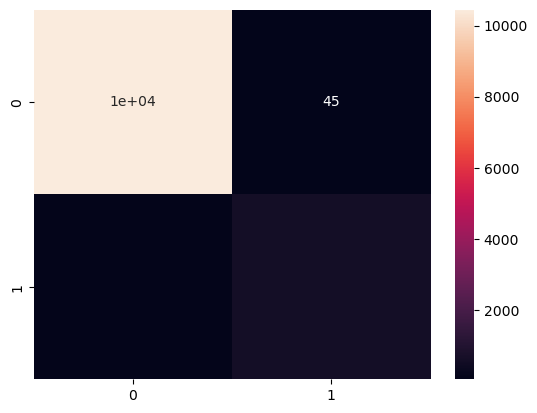

In [29]:
class_report = classification_report(actual_labels, test_pred)
print("Classification Report:\n", class_report)

total_test_loss = test_loss/len(test_dataloader) 
accuracy=accuracy_score(actual_labels, test_pred)
if n_categories > 2:
    precision=precision_score(actual_labels, test_pred, average='macro')
    recall=recall_score(actual_labels, test_pred, average='macro')
    f1=f1_score(actual_labels, test_pred, average='macro')
else:
    precision=precision_score(actual_labels, test_pred)
    recall=recall_score(actual_labels, test_pred)
    f1=f1_score(actual_labels, test_pred)
    roc_auc=roc_auc_score(actual_labels, test_pred)
f2 = (5*precision*recall) / (4*precision+recall)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))
if roc_auc:
    print("Roc_Auc score:%.2f%%"%(roc_auc*100))

conf_matrix = confusion_matrix(actual_labels, test_pred)
tn, fp, fn, tp = conf_matrix.ravel()
#acc = ((tp+tn)/(tp+tn+fp+fn))

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)
#print(conf_matrix)
sn.heatmap(conf_matrix, annot=True)

Export classification report

In [ ]:
method = "forSequence"

In [ ]:
# Create the path
path = os.path.join(root_path, 'results', model_variation.split("/")[-1], method, str(seed))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{seed}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


Compute the average values of the classication metrics considering the results for all different seeders

In [ ]:
# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", model_variation.split("/")[-1], method)

for root, dirs, files in os.walk(results_folder):
    for filename in files:
        if filename.endswith(".csv") and filename != "avg.csv":
            csv_file_path = os.path.join(root, filename)

            with open(csv_file_path, "r", newline="") as csvfile:
                reader = csv.DictReader(csvfile)

                for row in reader:
                    for metric, value in row.items():
                        cumulative_metrics[metric] += float(value)
            count += 1
        
# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values 
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", model_variation.split("/")[-1], method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)